# Train Koopman Neural Forecaster on TCTracks data

For demonstration, we nere train the Koopman Neural Forecaster for a small number of epochs on an exemplary dataset of tropical cyclone tracks.

In [1]:
import torch
import numpy as np
from torch.utils import data
from climada.hazard import TCTracks
# from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from klearn_tcyclone.knf_data_utils import TCTrackDataset

from klearn_tcyclone.KNF.modules.models import Koopman

from torch import nn

import time
from klearn_tcyclone.KNF.modules.train_utils import eval_epoch_koopman
# from klearn_tcyclone.KNF.modules.train_utils import get_lr
from klearn_tcyclone.KNF.modules.train_utils import train_epoch_koopman
from klearn_tcyclone.KNF.modules.eval_metrics import RMSE

from matplotlib import pyplot as plt

Import example TCTracks data.

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-21 11:21:54,102 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


Split TCTracks into train and test datasets.

In [3]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

Set model and training parameter.

In [4]:
seed=0 
dataset="Traj" 
data_dir="data/PlayerTraj/" 
num_feats=2 
train_output_length=15 
input_dim=3 
input_length=21 
hidden_dim=128 
latent_dim=32 
num_layers=4 
control_num_layers=3 
control_hidden_dim=64 
transformer_dim=64 
transformer_num_layers=3 
batch_size=32
test_output_length=30 
num_steps=15 
jumps=2 
learning_rate=0.001 
num_epochs = 5

encoder_hidden_dim = hidden_dim
decoder_hidden_dim = hidden_dim
encoder_num_layers = num_layers
decoder_num_layers = num_layers
output_dim = input_dim
# _REGULARIZE_RANK = flags.DEFINE_bool(
#     "regularize_rank", False, "Whether to regularize dynamics module rank.")

# _USE_REVIN = flags.DEFINE_bool("use_revin", True,
#                                "Whether to use reinversible normalization.")

# _USE_INSTANCENORM = flags.DEFINE_bool("use_instancenorm", True,
#                                       "Whether to use instance normalization.")

# _ADD_GLOBAL_OPERATOR = flags.DEFINE_bool(
#     "add_global_operator", True, "Whether to use a gloabl Koopman operator.")

# _ADD_CONTROL = flags.DEFINE_bool("add_control", True,
#                                  "Whether to use a control module.")

# _NUM_SINS = flags.DEFINE_integer("num_sins", -1, "number of sine functions.")

# _NUM_POLY = flags.DEFINE_integer("num_poly", -1, "number of sine functions.")

# _NUM_EXP = flags.DEFINE_integer("num_exp", -1, "number of sine functions.")

# _NUM_HEADS = flags.DEFINE_integer("num_heads", 1, "Transformer number of heads")

# _DROPOUT_RATE = flags.DEFINE_float("dropout_rate", 0.0, "The dropout rate.")

# _DECAY_RATE = flags.DEFINE_float("decay_rate", 0.9, "The learning decay rate.")

# _MIN_EPOCHS = flags.DEFINE_integer(
#     "min_epochs", 60, "The minimum number of epochs the model is trained with.")
use_revin = True
use_instancenorm = True
regularize_rank = False
add_global_operator = True
add_control = True
num_sins = -1
num_poly = -1
num_exp = -1
num_heads = 1
dropout_rate = 0
decay_rate = 0.9
min_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define evaluation metric and train, eval and test datasets.

In [5]:
eval_metric = RMSE
feature_list = ["lat", "lon"]
# feature_list = ["lat", "lon", "central_pressure"]
dataset = TCTrackDataset
dataset_str = "TCTracks"

train_set = TCTrackDataset(
    input_length=input_length,
    output_length=train_output_length,
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="train",
    jumps=jumps,
)
valid_set = TCTrackDataset(
    input_length=input_length,
    output_length=train_output_length,
    tc_tracks=tc_tracks_train,
    feature_list=feature_list,
    mode="valid",
    jumps=jumps,
)
test_set = TCTrackDataset(
    input_length=input_length,
    output_length=test_output_length,
    tc_tracks=tc_tracks_test,
    feature_list=feature_list,
    mode="test",
    # jumps=jumps,
)



In [6]:
train_loader = data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=1
)
valid_loader = data.DataLoader(
    valid_set, batch_size=batch_size, shuffle=True, num_workers=1
)
test_loader = data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=1
  )

Set up model name and model for training.

In [7]:
model_name = (
    "Koopman_"
    + dataset_str
    + "_seed{}_jumps{}_poly{}_sin{}_exp{}_bz{}_lr{}_decay{}_dim{}_inp{}_pred{}_num{}_enchid{}_dechid{}_trm{}_conhid{}_enclys{}_declys{}_trmlys{}_conlys{}_latdim{}_RevIN{}_insnorm{}_regrank{}_globalK{}_contK{}"
    .format(
        seed,
        jumps,
        num_poly,
        num_sins,
        num_exp,
        batch_size,
        learning_rate,
        decay_rate,
        input_dim,
        input_length,
        train_output_length,
        num_steps,
        encoder_hidden_dim,
        decoder_hidden_dim,
        transformer_dim,
        control_hidden_dim,
        encoder_num_layers,
        decoder_num_layers,
        transformer_num_layers,
        control_num_layers,
        latent_dim,
        use_revin,
        use_instancenorm,
        regularize_rank,
        add_global_operator,
        add_control,
    )
)
print(model_name)

model = Koopman(
    # number of steps of historical observations encoded at every step
    input_dim=input_dim,
    # input length of ts
    input_length=input_length,
    # number of output features
    output_dim=output_dim,
    # number of prediction steps every forward pass
    num_steps=num_steps,
    # hidden dimension of encoder
    encoder_hidden_dim=encoder_hidden_dim,
    # hidden dimension of decoder
    decoder_hidden_dim=decoder_hidden_dim,
    # number of layers in the encoder
    encoder_num_layers=encoder_num_layers,
    # number of layers in the decoder
    decoder_num_layers=decoder_num_layers,
    # number of feature
    num_feats=num_feats,
    # dimension of finite koopman space
    latent_dim=latent_dim,
    # whether to learn a global operator shared across all time series
    add_global_operator=add_global_operator,
    # whether to use a feedback module
    add_control=add_control,
    # hidden dim in the control module
    control_hidden_dim=control_hidden_dim,
    # number of layers in the control module
    use_revin=use_revin,  # whether to use reversible normalization
    control_num_layers=control_num_layers,
    # whether to use instance normalization on hidden states
    use_instancenorm=use_instancenorm,
    # Regularize rank.
    regularize_rank=regularize_rank,
    # number of pairs of sine and cosine measurement functions
    num_sins=num_sins,
    # the highest order of polynomial functions
    num_poly=num_poly,
    # number of exponential functions
    num_exp=num_exp,
    # Number of the head the transformer encoder
    num_heads=num_heads,
    # hidden dimension of tranformer encoder
    transformer_dim=transformer_dim,
    # number of layers in the transformer encoder
    transformer_num_layers=transformer_num_layers,
    # dropout rate of MLP modules
    dropout_rate=dropout_rate
).to(device)

Koopman_TCTracks_seed0_jumps2_poly-1_sin-1_exp-1_bz32_lr0.001_decay0.9_dim3_inp21_pred15_num15_enchid128_dechid128_trm64_conhid64_enclys4_declys4_trmlys3_conlys3_latdim32_RevINTrue_insnormTrue_regrankFalse_globalKTrue_contKTrue


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
print("number of params:",
    sum(p.numel() for p in model.parameters() if p.requires_grad))

number of params: 134944


Set upt optimizer and training scheduler.

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=decay_rate
)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

We test the training run for a small number of epochs (takes around 2min on CPU).

In [10]:
num_epochs = 5
last_epoch = 0

In [11]:
all_train_rmses, all_eval_rmses = [], []
best_eval_rmse = 1e6

for epoch in range(last_epoch, num_epochs):
    start_time = time.time()

    train_rmse = train_epoch_koopman(
        train_loader,
        model,
        loss_fun,
        optimizer,
        regularize_rank=regularize_rank)
    eval_rmse, _, _ = eval_epoch_koopman(
        valid_loader, model, loss_fun, regularize_rank=regularize_rank)

    if eval_rmse < best_eval_rmse:
        best_eval_rmse = eval_rmse
        best_model = model
        # torch.save([best_model, epoch, get_lr(optimizer)],
        #             results_dir + model_name + ".pth")

    all_train_rmses.append(train_rmse)
    all_eval_rmses.append(eval_rmse)

    if np.isnan(train_rmse) or np.isnan(eval_rmse):
        raise ValueError("The model generate NaN values")

    # # train the model at least 60 epochs and do early stopping
    # if epoch > min_epochs and np.mean(all_eval_rmses[-10:]) > np.mean(
    #     all_eval_rmses[-20:-10]):
    #     break

    epoch_time = time.time() - start_time
    scheduler.step()
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.3f} | Valid RMSE: {:0.3f}"
            .format(epoch + 1, epoch_time / 60, train_rmse, eval_rmse))



d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\torch\nn\modules\instancenorm.py:88: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\torch\nn\modules\instancenorm.py:88: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Epoch 1 | T: 0.39 | Train RMSE: 9.318 | Valid RMSE: 1.453
Epoch 2 | T: 0.34 | Train RMSE: 1.395 | Valid RMSE: 1.087
Epoch 3 | T: 0.34 | Train RMSE: 1.172 | Valid RMSE: 1.062
Epoch 4 | T: 0.35 | Train RMSE: 0.962 | Valid RMSE: 0.759
Epoch 5 | T: 0.34 | Train RMSE: 0.921 | Valid RMSE: 0.952


Text(0, 0.5, 'RMSE')

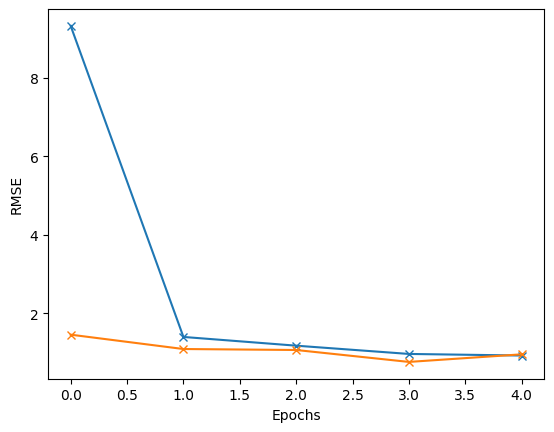

In [17]:
epochs = range(last_epoch, num_epochs)
plt.plot(epochs, all_train_rmses, "-x", label="Train RMSE")
plt.plot(epochs, all_eval_rmses, "-x", label="Eval RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")

Looks good. We observe a reduction of train and eval rmse over epochs.

Evaluating test RMSE.

In [13]:
test_rmse, test_preds, test_tgts = eval_epoch_koopman(test_loader, best_model,
                                                loss_fun)

In [14]:
test_rmse, test_preds.shape, test_tgts.shape

(1.8323278126088975, (3, 30, 2), (3, 30, 2))